In [532]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
class MACDRSIStrategy(CtaTemplate):
    className = 'MACDRSIStrategy'
    author = 'Carey'
    # 策略参数
    DIFFfastPeriod = 12; DIFFslowPeriod = 26; DEAPeriod = 9   #经参数优化，非核心参数
    filterPeriod = 90  #经参数优化，非核心参数
    a = 1.07; b = 0.95
    obv6Period = 6; obv12Period = 12 #经参数优化，核心参数
    stopRatio = 0.04
    lot = 1
    # 策略变量
    transactionPrice = {} # 记录成交价格
    trend = {}
    # 参数列表，保存了参数的名称
    paramList = [
                 "DIFFfastPeriod", "DIFFslowPeriod", "DEAPeriod",
                 "filterPeriod",
                 "a" , "b",
                 "obv6Period", "obv12Period",
                 'stopRatio']                        ##参数列表不用写手数
    # 变量列表，保存了变量的名称
    varList = ['transactionPrice'
                  "trend"]  
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把本策略对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.trend = {s:0 for s in self.symbolList}
        self.putEvent()
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
        
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #############大周期成交量上涨下跌单边趋势，添加吞噬蜡烛图做反转信号，价格高位做空，价格低位做多，能量潮做过滤################################# 
    
    def on60MinBar(self, bar):
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m")
        if not am60.inited:
            return
        #大周期判断趋势，成交量的MACD来判断上涨和下跌趋势
        DIFF = ta.EMA(am60.volume, self.DIFFfastPeriod) - ta.EMA(am60.volume, self.DIFFslowPeriod)
        DEA = ta.EMA(DIFF, self.DEAPeriod)
        if (DIFF[-1]>DEA[-1]): 
            self.trend[symbol] = 1
        elif (DIFF[-1]<DEA[-1]): 
            self.trend[symbol] = -1
        self.putEvent()
        
    def on30MinBar(self, bar):
        symbol = bar.vtSymbol
        am30 = self.getArrayManager(symbol, "30m")
        if not am30.inited:
            return
        #用蜡烛图吞噬模式来观察进出场信号，蜡烛图=100为看多信号，蜡烛图=-100为看空信号
        integer = ta.CDLENGULFING(am30.open, am30.high, am30.low, am30.close)
        #特定周期内价格处于顶部和底部进行初步过滤，特定周期内最高价判断处于顶部，最低价判断处于价底部。a和b为修正参数。
        Highest = ta.MAX(am30.close,timeperiod=self.filterPeriod)
        Lowest = ta.MIN(am30.close,timeperiod=self.filterPeriod)        
        long = am30.close[-1]<=self.a*Lowest[-1]
        short = am30.close[-1]>=self.b*Highest[-1]            
        #能量潮做过滤，当快线能量潮处于慢线能量潮上方，为上涨趋势，下方为下跌趋势。
        obv = ta.OBV(am30.close,am30.volume)
        obv_6 = ta.MA(obv,self.obv6Period)
        obv_12 = ta.MA(obv,self.obv12Period)
        long_obv = obv_6[-1] > obv_12[-1] 
        short_obv = obv_12[-1] < obv_6[-1]
 
        # 趋势为多头
        if (integer[-1]==100) and (long_obv and long) and (self.trend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):  
            if  (self.posDict[symbol+'_SHORT']==0):  #没有持仓
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 趋势为空头
        if (integer[-1]==-100) and (short_obv and short) and (self.trend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0): 
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)

                
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
#             print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [533]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
# 创建回测引擎对象
engine = BacktestingEngine()
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181220 12:00') # 设置回测用的数据终止日期
# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(100000)  # 设置回测本金

In [534]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDRSIStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 19:20:55.911220	开始回测
2018-12-23 19:20:55.911287	策略初始化
2018-12-23 19:20:56.438785	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 19:20:56.438971	初始化预加载数据成功, 数据长度:12000
2018-12-23 19:20:56.439010	策略初始化完成
2018-12-23 19:20:56.439026	策略启动完成
2018-12-23 19:20:56.439066	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 19:20:56.439092	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 19:21:09.758108	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 19:21:09.947389	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 19:21:12.322751	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 19:21:12.328753	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:16.313507	Progress: 4%    
SHORT stopLoss21:16.905333	Progress: 8%    
SHORT takeProfit:17.355918	Progress: 11%    
SHORT stopLoss21:17.803732	Progress: 14%    
SHORT stopLoss21:17.952509	P

In [535]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('tradeDatetime')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
tradeDatetime,,,,,,,,,,,,,,,,,,
2018-12-16 21:00:00,空,,,0.0,,开仓,195,,3259.17,None,,,195,20181216 21:00:00,1,195,BTCUSDT:binance,195
2018-12-17 20:00:00,多,,,0.0,,平仓,196,,3271.86,None,,,196,20181217 20:00:00,1,196,BTCUSDT:binance,196
2018-12-17 20:00:00,多,,,0.0,,开仓,197,,3271.86,None,,,197,20181217 20:00:00,1,197,BTCUSDT:binance,197
2018-12-19 07:32:00,空,,,0.0,,平仓,198,,3672.39,None,,,198,20181219 07:32:00,1,198,BTCUSDT:binance,198
2018-12-20 11:00:00,空,,,0.0,,开仓,199,,3717.83,None,,,199,20181220 11:00:00,1,199,BTCUSDT:binance,199


2018-12-23 19:23:30.944902	计算按日统计结果
2018-12-23 19:23:30.975539	------------------------------
2018-12-23 19:23:30.975643	首个交易日：	2018-06-01 00:00:00
2018-12-23 19:23:30.975674	最后交易日：	2018-12-20 00:00:00
2018-12-23 19:23:30.975698	总交易日：	203
2018-12-23 19:23:30.975722	盈利交易日	101
2018-12-23 19:23:30.975746	亏损交易日：	77
2018-12-23 19:23:30.975770	起始资金：	100000
2018-12-23 19:23:30.975824	结束资金：	105,841.65
2018-12-23 19:23:30.975864	总收益率：	5.84%
2018-12-23 19:23:30.975900	年化收益：	6.91%
2018-12-23 19:23:30.975936	总盈亏：	5,841.65
2018-12-23 19:23:30.975975	最大回撤: 	-1,345.31
2018-12-23 19:23:30.976016	百分比最大回撤: -1.33%
2018-12-23 19:23:30.976052	总手续费：	627.14
2018-12-23 19:23:30.976087	总滑点：	0.4
2018-12-23 19:23:30.976123	总成交金额：	1,254,283.05
2018-12-23 19:23:30.976154	总成交笔数：	199
2018-12-23 19:23:30.976188	日均盈亏：	28.78
2018-12-23 19:23:30.976223	日均手续费：	3.09
2018-12-23 19:23:30.976257	日均滑点：	0.0
2018-12-23 19:23:30.976292	日均成交金额：	6,178.73
2018-12-23 19:23:30.976328	日均成交笔数：	0.98
2018-12-23 19:23:30.976357	日均收益率：	0.0

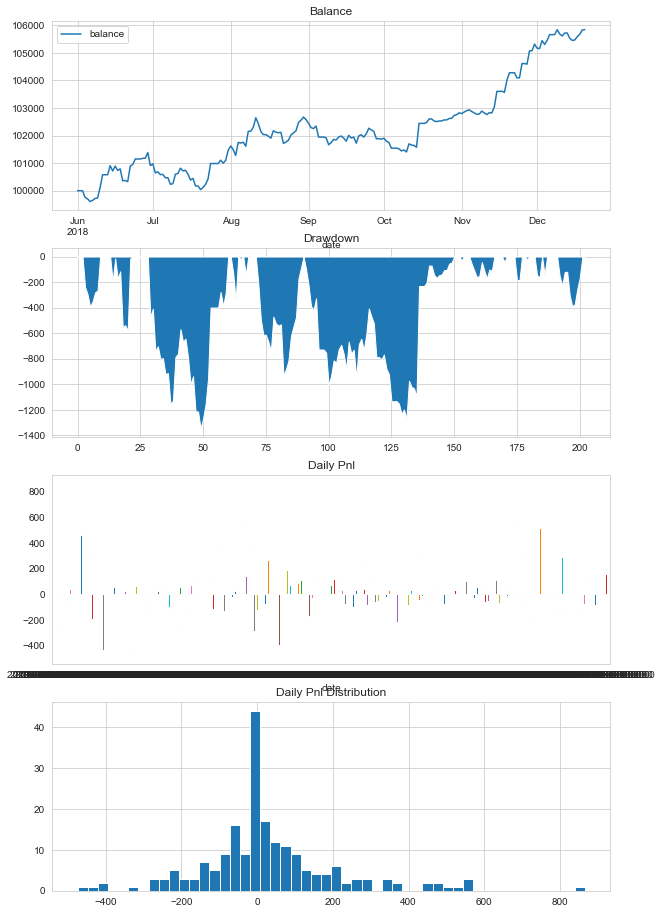

In [536]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-23 19:23:35.872823	计算回测结果
2018-12-23 19:23:35.882102	------------------------------
2018-12-23 19:23:35.882246	第一笔交易：	2018-06-05 06:30:00
2018-12-23 19:23:35.882277	最后一笔交易：	2018-12-20 11:58:00
2018-12-23 19:23:35.882307	总交易次数：	100
2018-12-23 19:23:35.882338	总盈亏：	5,839.8
2018-12-23 19:23:35.882368	最大回撤: 	-1,174.93
2018-12-23 19:23:35.882394	平均每笔盈利：	58.4
2018-12-23 19:23:35.882420	平均每笔滑点：	0.0
2018-12-23 19:23:35.882446	平均每笔佣金：	6.29
2018-12-23 19:23:35.882471	胜率		47.0%
2018-12-23 19:23:35.882497	盈利交易平均值	246.02
2018-12-23 19:23:35.882522	亏损交易平均值	-107.99
2018-12-23 19:23:35.882548	盈亏比：	2.28


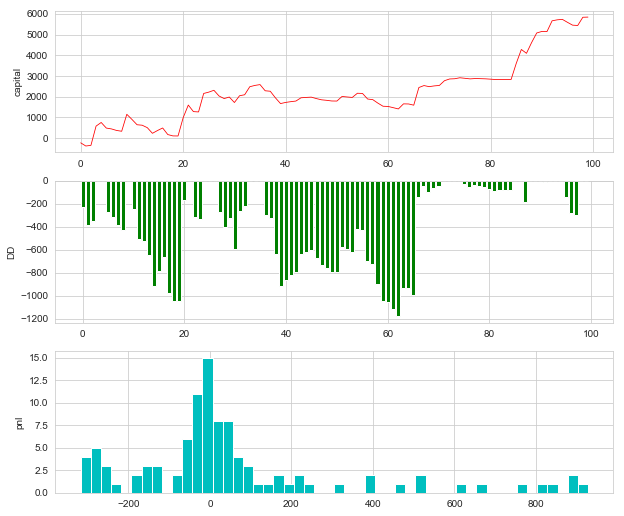

In [537]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [538]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-23 19:23:39.617839	计算按日统计结果


In [539]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-06-01 00:00:00
endDate             2018-12-20 00:00:00
totalDays                           203
profitDays                          101
lossDays                             77
endBalance                       105842
maxDrawdown                    -1345.31
maxDdPercent                   -1.32694
totalNetPnl                     5841.65
dailyNetPnl                     28.7766
totalCommission                 627.142
dailyCommission                 3.08937
totalSlippage                     0.398
dailySlippage                0.00196059
totalTurnover               1.25428e+06
dailyTurnover                   6178.73
totalTradeCount                     199
dailyTradeCount                0.980296
totalReturn                     5.84165
annualizedReturn                6.90638
dailyReturn                   0.0287766
returnStd                      0.184699
sharpeRatio                     2.41368
dtype: object


In [486]:
####参数优化

In [491]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter("a", 1.00, 1.10, 0.01)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter("b", 0.90, 1.00, 0.01)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5
setting.addParameter('symbolList', ['BTCUSDT:binance']) 
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MACDRSIStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-23 17:32:07.046529	------------------------------
2018-12-23 17:32:07.046703	setting: {'a': 1.0, 'b': 0.9, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 17:32:07.071516	开始回测
2018-12-23 17:32:07.071684	策略初始化
2018-12-23 17:32:07.579127	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 17:32:07.579328	初始化预加载数据成功, 数据长度:12000
2018-12-23 17:32:07.579376	策略初始化完成
2018-12-23 17:32:07.579400	策略启动完成
2018-12-23 17:32:07.579440	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 17:32:07.579472	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 17:32:20.988358	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 17:32:21.201343	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 17:32:23.650277	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 17:32:23.656531	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:28.160911	Progress: 5%    
SHORT stopLo

2018-12-23 17:34:36.115944	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 17:34:36.116146	初始化预加载数据成功, 数据长度:12000
2018-12-23 17:34:36.116209	策略初始化完成
2018-12-23 17:34:36.116235	策略启动完成
2018-12-23 17:34:36.116270	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 17:34:36.116301	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 17:34:49.421830	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 17:34:49.621284	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 17:34:52.041998	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 17:34:52.047370	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:56.715670	Progress: 5%    
SHORT stopLoss34:57.202176	Progress: 8%    
SHORT takeProfit:57.663027	Progress: 11%    
SHORT stopLoss34:58.126267	Progress: 14%    
SHORT stopLoss34:58.287126	Progress: 15%    
SHORT stopLoss34:59.523740	Progress: 22%    
SHORT stopLoss35:00.095404	Progress: 25%    
SHORT takeProfit:01.170153	Pro

SHORT stopLoss37:28.363288	Progress: 22%    
SHORT stopLoss37:28.825278	Progress: 25%    
SHORT takeProfit:29.734487	Progress: 31%    
SHORT stopLoss37:31.082139	Progress: 40%    
SHORT stopLoss37:31.537218	Progress: 43%    
SHORT stopLoss37:32.146532	Progress: 47%    
SHORT stopLoss37:33.416284	Progress: 55%    
SHORT stopLoss37:35.315531	Progress: 67%    
SHORT takeProfit:37.704294	Progress: 82%    
SHORT stopLoss37:40.330799	Progress: 99%    
2018-12-23 17:37:40.499835	回放结束ress: 100%    
2018-12-23 17:37:40.499910	计算按日统计结果
2018-12-23 17:37:40.642146	------------------------------
2018-12-23 17:37:40.642220	setting: {'a': 1.0, 'b': 0.9900000000000001, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 17:37:40.671052	开始回测
2018-12-23 17:37:40.671295	策略初始化
2018-12-23 17:37:41.185456	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 17:37:41.185662	初始化预加载数据成功, 数据长度:12000
2018-12-23 17:37:41.185711	策略初始化完成


SHORT stopLoss40:26.591425	Progress: 8%    
SHORT takeProfit:27.083535	Progress: 11%    
SHORT stopLoss40:27.582678	Progress: 14%    
SHORT stopLoss40:27.759395	Progress: 15%    
SHORT stopLoss40:28.833330	Progress: 22%    
SHORT stopLoss40:29.403714	Progress: 25%    
SHORT takeProfit:30.466345	Progress: 31%    
SHORT stopLoss40:32.000071	Progress: 40%    
SHORT stopLoss40:32.210044	Progress: 41%    
SHORT stopLoss40:32.580392	Progress: 43%    
SHORT stopLoss40:33.225465	Progress: 47%    
SHORT stopLoss40:33.562945	Progress: 49%    
SHORT stopLoss40:34.500786	Progress: 55%    
SHORT stopLoss40:36.668907	Progress: 67%    
SHORT takeProfit:39.018191	Progress: 82%    
SHORT takeProfit:39.338887	Progress: 84%    
SHORT takeProfit:39.800781	Progress: 87%    
SHORT stopLoss40:40.112943	Progress: 89%    
SHORT takeProfit:40.570558	Progress: 92%    
SHORT takeProfit:40.731776	Progress: 93%    
SHORT stopLoss40:41.493227	Progress: 98%    
2018-12-23 17:40:41.808714	回放结束ress: 100%    
2018-12-23

SHORT stopLoss43:00.421973	Progress: 22%    
SHORT stopLoss43:00.966813	Progress: 25%    
SHORT takeProfit:01.937760	Progress: 31%    
SHORT stopLoss43:03.437778	Progress: 40%    
SHORT stopLoss43:03.945675	Progress: 43%    
SHORT stopLoss43:04.625952	Progress: 47%    
SHORT stopLoss43:05.997599	Progress: 55%    
SHORT stopLoss43:07.971790	Progress: 67%    
SHORT takeProfit:10.427921	Progress: 82%    
SHORT takeProfit:10.734216	Progress: 84%    
SHORT takeProfit:11.220254	Progress: 87%    
LONG takeProfit3:11.525181	Progress: 89%    
SHORT takeProfit:11.998912	Progress: 92%    
LONG stopLoss:43:12.800755	Progress: 97%    
SHORT stopLoss43:12.959098	Progress: 98%    
2018-12-23 17:43:13.278256	回放结束ress: 100%    
2018-12-23 17:43:13.278390	计算按日统计结果
2018-12-23 17:43:13.383380	------------------------------
2018-12-23 17:43:13.383442	setting: {'a': 1.01, 'b': 0.9700000000000001, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-

SHORT stopLoss46:01.059800	Progress: 8%    
SHORT takeProfit:01.519560	Progress: 11%    
SHORT stopLoss46:01.978224	Progress: 14%    
SHORT stopLoss46:02.134611	Progress: 15%    
SHORT stopLoss46:03.213215	Progress: 22%    
SHORT stopLoss46:03.665881	Progress: 25%    
SHORT takeProfit:04.575668	Progress: 31%    
SHORT stopLoss46:05.930395	Progress: 40%    
SHORT stopLoss46:06.083481	Progress: 41%    
SHORT stopLoss46:06.987324	Progress: 47%    
LONG stopLoss:46:07.294029	Progress: 49%    
SHORT stopLoss
SHORT stopLoss46:08.204295	Progress: 55%    
LONG takeProfit6:10.024323	Progress: 67%    
SHORT takeProfit:12.284826	Progress: 82%    
SHORT takeProfit:12.592399	Progress: 84%    
SHORT takeProfit:13.048097	Progress: 87%    
SHORT stopLoss46:13.355731	Progress: 89%    
SHORT takeProfit:13.817962	Progress: 92%    
SHORT takeProfit:13.967675	Progress: 93%    
SHORT stopLoss46:14.721848	Progress: 98%    
2018-12-23 17:46:15.027244	回放结束ress: 100%    
2018-12-23 17:46:15.027318	计算按日统计结果
2018

SHORT stopLoss48:22.213328	Progress: 25%    
SHORT takeProfit:23.123687	Progress: 31%    
SHORT stopLoss48:24.495353	Progress: 40%    
SHORT stopLoss48:24.649028	Progress: 41%    
SHORT stopLoss48:25.551877	Progress: 47%    
LONG stopLoss:48:25.857798	Progress: 49%    
SHORT stopLoss
SHORT stopLoss48:26.798785	Progress: 55%    
LONG takeProfit8:28.635047	Progress: 67%    
SHORT takeProfit:30.991026	Progress: 82%    
SHORT takeProfit:31.352201	Progress: 84%    
SHORT takeProfit:31.824118	Progress: 87%    
LONG takeProfit8:32.126653	Progress: 89%    
SHORT takeProfit:32.584522	Progress: 92%    
SHORT stopLoss48:33.504283	Progress: 98%    
2018-12-23 17:48:33.818430	回放结束ress: 100%    
2018-12-23 17:48:33.818526	计算按日统计结果
2018-12-23 17:48:33.928009	------------------------------
2018-12-23 17:48:33.928126	setting: {'a': 1.02, 'b': 0.9500000000000001, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 17:48:33.948061	开始回测
201

2018-12-23 17:50:52.362880	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 17:50:52.363091	初始化预加载数据成功, 数据长度:12000
2018-12-23 17:50:52.363141	策略初始化完成
2018-12-23 17:50:52.363196	策略启动完成
2018-12-23 17:50:52.363238	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 17:50:52.363270	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 17:51:04.680730	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 17:51:04.860357	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 17:51:07.014435	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 17:51:07.020402	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:10.969621	Progress: 4%    
SHORT takeProfit:12.035258	Progress: 11%    
SHORT stopLoss51:13.720514	Progress: 22%    
SHORT takeProfit:15.090642	Progress: 31%    
SHORT stopLoss51:16.457895	Progress: 40%    
SHORT stopLoss51:17.524280	Progress: 47%    
LONG stopLoss:51:17.841445	Progress: 49%    
LONG stopLoss:51:18.455986	Pr

SHORT stopLoss53:28.544844	Progress: 8%    
SHORT takeProfit:29.001101	Progress: 11%    
SHORT stopLoss53:29.454234	Progress: 14%    
SHORT stopLoss53:29.615631	Progress: 15%    
SHORT stopLoss53:29.928314	Progress: 17%    
SHORT stopLoss53:30.694473	Progress: 22%    
LONG takeProfit3:31.315844	Progress: 26%    
LONG stopLoss:53:31.934751	Progress: 30%    
SHORT takeProfit:32.402116	Progress: 33%    
SHORT stopLoss53:33.486591	Progress: 40%    
SHORT stopLoss53:33.649422	Progress: 41%    
SHORT stopLoss53:34.424570	Progress: 46%    
LONG stopLoss:53:34.584329	Progress: 47%    
LONG stopLoss:53:34.892428	Progress: 49%    
SHORT stopLoss
SHORT stopLoss53:35.832747	Progress: 55%    
SHORT stopLoss53:36.296104	Progress: 58%    
LONG takeProfit3:37.692484	Progress: 67%    
SHORT takeProfit:39.980667	Progress: 82%    
SHORT takeProfit:40.289514	Progress: 84%    
SHORT takeProfit:40.754794	Progress: 87%    
SHORT stopLoss53:41.057726	Progress: 89%    
SHORT takeProfit:41.513163	Progress: 92% 

2018-12-23 17:55:38.740254	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 17:55:38.921097	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 17:55:41.078692	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 17:55:41.085355	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:45.163033	Progress: 5%    
SHORT stopLoss55:45.626878	Progress: 8%    
SHORT takeProfit:46.078920	Progress: 11%    
SHORT stopLoss55:46.537279	Progress: 14%    
SHORT stopLoss55:46.697056	Progress: 15%    
SHORT stopLoss55:47.010055	Progress: 17%    
SHORT stopLoss55:47.784600	Progress: 22%    
LONG takeProfit5:48.397091	Progress: 26%    
LONG stopLoss:55:49.011049	Progress: 30%    
SHORT takeProfit:49.468055	Progress: 33%    
SHORT stopLoss55:50.532745	Progress: 40%    
SHORT stopLoss55:51.445311	Progress: 46%    
LONG stopLoss:55:51.608364	Progress: 47%    
LONG stopLoss:55:51.919681	Progress: 49%    
SHORT stopLoss55:52.838042	Progress: 55%    
SHOR

LONG stopLoss:58:02.122796	Progress: 10%    
LONG stopLoss:58:03.488249	Progress: 19%    
LONG takeProfit8:04.559283	Progress: 26%    
LONG stopLoss:58:05.169057	Progress: 30%    
LONG stopLoss:58:05.323844	Progress: 31%    
LONG takeProfit8:07.443532	Progress: 45%    
LONG stopLoss:58:07.746257	Progress: 47%    
LONG stopLoss:58:08.045566	Progress: 49%    
LONG takeProfit8:10.764809	Progress: 67%    
LONG stopLoss:58:11.834363	Progress: 74%    
LONG stopLoss:58:13.050992	Progress: 82%    
LONG takeProfit8:14.116332	Progress: 89%    
LONG stopLoss:58:15.180835	Progress: 96%    
LONG stopLoss:58:15.339343	Progress: 97%    
2018-12-23 17:58:15.801109	回放结束ress: 100%    
2018-12-23 17:58:15.801200	计算按日统计结果
2018-12-23 17:58:15.909988	------------------------------
2018-12-23 17:58:15.910424	setting: {'a': 1.04, 'b': 0.9, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 17:58:15.932237	开始回测
2018-12-23 17:58:15.932317	策略初始化


SHORT takeProfit:17.413596	Progress: 4%    
SHORT stopLoss00:18.022643	Progress: 8%    
SHORT takeProfit:18.478313	Progress: 11%    
SHORT stopLoss00:18.932024	Progress: 14%    
SHORT stopLoss00:19.087264	Progress: 15%    
SHORT stopLoss00:19.406084	Progress: 17%    
SHORT stopLoss00:20.167331	Progress: 22%    
LONG takeProfit0:20.766644	Progress: 26%    
LONG stopLoss:00:21.386390	Progress: 30%    
SHORT takeProfit:21.850553	Progress: 33%    
SHORT stopLoss00:22.940565	Progress: 40%    
SHORT stopLoss00:23.861671	Progress: 46%    
LONG stopLoss:00:24.018937	Progress: 47%    
LONG stopLoss:00:24.318974	Progress: 49%    
SHORT stopLoss
SHORT stopLoss00:25.217082	Progress: 55%    
SHORT stopLoss00:25.675893	Progress: 58%    
LONG takeProfit0:27.075639	Progress: 67%    
SHORT takeProfit:29.382867	Progress: 82%    
SHORT takeProfit:29.688266	Progress: 84%    
LONG stopLoss:00:29.990430	Progress: 86%    
SHORT takeProfit:30.139646	Progress: 87%    
SHORT stopLoss00:30.461194	Progress: 89%  

2018-12-23 18:02:27.493945	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:02:27.671035	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 18:02:29.831914	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 18:02:29.837870	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:33.755877	Progress: 4%    
SHORT takeProfit:34.810935	Progress: 11%    
SHORT stopLoss02:35.275387	Progress: 14%    
SHORT stopLoss02:35.430730	Progress: 15%    
SHORT stopLoss02:35.745478	Progress: 17%    
SHORT stopLoss02:36.500730	Progress: 22%    
LONG takeProfit2:37.121709	Progress: 26%    
LONG stopLoss:02:37.737337	Progress: 30%    
SHORT takeProfit:38.196042	Progress: 33%    
SHORT stopLoss02:39.271716	Progress: 40%    
SHORT stopLoss02:40.179142	Progress: 46%    
LONG stopLoss:02:40.341337	Progress: 47%    
LONG stopLoss:02:40.651938	Progress: 49%    
SHORT stopLoss02:41.567936	Progress: 55%    
SHORT stopLoss02:42.025542	Progress: 58%    
LON

SHORT takeProfit:51.201337	Progress: 4%    
SHORT stopLoss04:51.804236	Progress: 8%    
SHORT takeProfit:52.256086	Progress: 11%    
SHORT stopLoss04:52.712512	Progress: 14%    
SHORT stopLoss04:52.873639	Progress: 15%    
SHORT stopLoss04:53.199257	Progress: 17%    
SHORT stopLoss04:53.958456	Progress: 22%    
LONG takeProfit4:54.569682	Progress: 26%    
LONG stopLoss:04:55.186931	Progress: 30%    
SHORT takeProfit:55.645425	Progress: 33%    
SHORT stopLoss04:56.712492	Progress: 40%    
SHORT stopLoss04:57.638412	Progress: 46%    
LONG stopLoss:04:57.798400	Progress: 47%    
LONG stopLoss:04:58.105944	Progress: 49%    
SHORT stopLoss
SHORT stopLoss04:59.025642	Progress: 55%    
SHORT stopLoss04:59.490940	Progress: 58%    
LONG takeProfit5:00.883749	Progress: 67%    
SHORT takeProfit:03.178631	Progress: 82%    
SHORT takeProfit:03.482064	Progress: 84%    
LONG stopLoss:05:03.788417	Progress: 86%    
SHORT takeProfit:03.942975	Progress: 87%    
SHORT stopLoss05:04.249058	Progress: 89%  

2018-12-23 18:06:48.576630	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 18:06:48.576836	初始化预加载数据成功, 数据长度:12000
2018-12-23 18:06:48.576885	策略初始化完成
2018-12-23 18:06:48.576909	策略启动完成
2018-12-23 18:06:48.576949	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 18:06:48.576995	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 18:07:00.860777	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:07:01.040610	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 18:07:03.531275	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 18:07:03.537355	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:07.473800	Progress: 4%    
SHORT stopLoss07:08.095847	Progress: 8%    
SHORT takeProfit:08.558232	Progress: 11%    
SHORT stopLoss07:09.021724	Progress: 14%    
SHORT stopLoss07:09.178159	Progress: 15%    
SHORT stopLoss07:09.485496	Progress: 17%    
SHORT stopLoss07:10.252467	Progress: 22%    
LONG takeProfit7:10.858455	Pro

LONG takeProfit9:07.041273	Progress: 89%    
SHORT takeProfit:07.701069	Progress: 93%    
LONG stopLoss:09:08.193186	Progress: 96%    
LONG stopLoss:09:08.359902	Progress: 97%    
LONG takeProfit9:08.667426	Progress: 99%    
2018-12-23 18:09:08.838906	回放结束ress: 100%    
2018-12-23 18:09:08.838984	计算按日统计结果
2018-12-23 18:09:08.961680	------------------------------
2018-12-23 18:09:08.961857	setting: {'a': 1.05, 'b': 0.9800000000000001, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 18:09:08.983643	开始回测
2018-12-23 18:09:08.983713	策略初始化
2018-12-23 18:09:09.483178	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 18:09:09.483358	初始化预加载数据成功, 数据长度:12000
2018-12-23 18:09:09.483405	策略初始化完成
2018-12-23 18:09:09.483431	策略启动完成
2018-12-23 18:09:09.483471	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 18:09:09.483517	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 18:09:22.027249	数据载入完成, 时间段:[20180601 12:00,2

SHORT takeProfit:29.608245	Progress: 93%    
LONG stopLoss:11:30.099501	Progress: 96%    
LONG takeProfit1:30.589569	Progress: 99%    
2018-12-23 18:11:30.767094	回放结束ress: 100%    
2018-12-23 18:11:30.767256	计算按日统计结果
2018-12-23 18:11:30.889127	------------------------------
2018-12-23 18:11:30.889267	setting: {'a': 1.06, 'b': 0.91, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 18:11:30.910793	开始回测
2018-12-23 18:11:30.911022	策略初始化
2018-12-23 18:11:31.413033	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 18:11:31.413212	初始化预加载数据成功, 数据长度:12000
2018-12-23 18:11:31.413256	策略初始化完成
2018-12-23 18:11:31.413295	策略启动完成
2018-12-23 18:11:31.413334	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 18:11:31.413369	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 18:11:43.894120	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:11:44.075410	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:379

SHORT stopLoss13:42.971704	Progress: 40%    
SHORT stopLoss13:43.935205	Progress: 46%    
LONG stopLoss:13:44.099073	Progress: 47%    
LONG stopLoss:13:44.420377	Progress: 49%    
SHORT stopLoss
SHORT stopLoss13:45.877005	Progress: 58%    
LONG takeProfit3:47.351642	Progress: 67%    
SHORT takeProfit:49.797509	Progress: 82%    
SHORT takeProfit:50.132567	Progress: 84%    
LONG stopLoss:13:50.457551	Progress: 86%    
SHORT takeProfit:50.609086	Progress: 87%    
LONG takeProfit3:50.942179	Progress: 89%    
SHORT takeProfit:51.581484	Progress: 93%    
LONG stopLoss:13:52.083669	Progress: 96%    
LONG takeProfit3:52.564601	Progress: 99%    
2018-12-23 18:13:52.742130	回放结束ress: 100%    
2018-12-23 18:13:52.742217	计算按日统计结果
2018-12-23 18:13:52.868634	------------------------------
2018-12-23 18:13:52.868858	setting: {'a': 1.06, 'b': 0.9500000000000001, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 18:13:52.891870	开始回测
201

LONG stopLoss:15:59.544662	Progress: 1%    
SHORT takeProfit:00.032765	Progress: 4%    
SHORT takeProfit:01.165279	Progress: 11%    
SHORT stopLoss16:01.829768	Progress: 15%    
SHORT stopLoss16:02.978527	Progress: 22%    
LONG takeProfit6:03.630968	Progress: 26%    
LONG stopLoss:16:04.312409	Progress: 30%    
LONG stopLoss:16:04.480883	Progress: 31%    
LONG stopLoss:16:05.283935	Progress: 36%    
SHORT stopLoss16:05.925440	Progress: 40%    
SHORT stopLoss16:06.893330	Progress: 46%    
LONG stopLoss:16:07.058136	Progress: 47%    
LONG stopLoss:16:07.378366	Progress: 49%    
SHORT stopLoss16:08.831361	Progress: 58%    
LONG takeProfit6:10.299178	Progress: 67%    
SHORT takeProfit:12.745565	Progress: 82%    
LONG stopLoss:16:13.414556	Progress: 86%    
LONG takeProfit6:13.931267	Progress: 89%    
LONG stopLoss:16:14.258588	Progress: 91%    
LONG stopLoss:16:15.042558	Progress: 96%    
LONG stopLoss:16:15.197266	Progress: 97%    
LONG takeProfit6:15.516021	Progress: 99%    
2018-12-23 1

SHORT takeProfit:22.571188	Progress: 4%    
SHORT stopLoss18:23.236595	Progress: 8%    
SHORT takeProfit:23.738114	Progress: 11%    
SHORT stopLoss18:24.212209	Progress: 14%    
SHORT stopLoss18:24.379341	Progress: 15%    
SHORT stopLoss18:24.704317	Progress: 17%    
SHORT stopLoss18:25.510591	Progress: 22%    
LONG takeProfit8:26.165550	Progress: 26%    
LONG stopLoss:18:26.799744	Progress: 30%    
SHORT takeProfit:27.290933	Progress: 33%    
LONG stopLoss:18:27.778062	Progress: 36%    
SHORT stopLoss18:28.417765	Progress: 40%    
SHORT stopLoss18:29.380050	Progress: 46%    
LONG stopLoss:18:29.539365	Progress: 47%    
LONG stopLoss:18:29.854478	Progress: 49%    
SHORT stopLoss
SHORT stopLoss18:31.299131	Progress: 58%    
LONG takeProfit8:32.747177	Progress: 67%    
SHORT takeProfit:35.141684	Progress: 82%    
SHORT takeProfit:35.474046	Progress: 84%    
LONG stopLoss:18:35.798804	Progress: 86%    
SHORT takeProfit:35.958061	Progress: 87%    
SHORT stopLoss18:36.284810	Progress: 89%  

2018-12-23 18:20:38.676488	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:20:38.860651	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 18:20:41.479392	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 18:20:41.484693	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:45.733971	Progress: 4%    
SHORT stopLoss20:46.383973	Progress: 8%    
SHORT takeProfit:46.868458	Progress: 11%    
SHORT stopLoss20:47.366985	Progress: 14%    
SHORT stopLoss20:47.532944	Progress: 15%    
SHORT stopLoss20:47.871042	Progress: 17%    
SHORT stopLoss20:48.683506	Progress: 22%    
LONG takeProfit0:49.333071	Progress: 26%    
LONG stopLoss:20:49.997263	Progress: 30%    
SHORT takeProfit:50.477592	Progress: 33%    
LONG stopLoss:20:50.998507	Progress: 36%    
SHORT stopLoss20:51.645835	Progress: 40%    
SHORT stopLoss20:52.643375	Progress: 46%    
LONG stopLoss:20:52.808231	Progress: 47%    
LONG stopLoss:20:53.129763	Progress: 49%    
SHOR

2018-12-23 18:22:49.766113	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 18:22:49.766290	初始化预加载数据成功, 数据长度:12000
2018-12-23 18:22:49.766336	策略初始化完成
2018-12-23 18:22:49.766366	策略启动完成
2018-12-23 18:22:49.766406	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 18:22:49.766438	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 18:23:02.565753	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:23:02.769160	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 18:23:04.977058	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 18:23:04.983859	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
LONG stopLoss:23:08.751726	Progress: 1%    
SHORT takeProfit:09.240877	Progress: 4%    
SHORT takeProfit:10.380070	Progress: 11%    
SHORT stopLoss23:12.117514	Progress: 22%    
LONG takeProfit3:12.759618	Progress: 26%    
LONG stopLoss:23:13.414393	Progress: 30%    
LONG stopLoss:23:13.579661	Progress: 31%    
LONG stopLoss:23:14.059272	Pro

2018-12-23 18:25:13.098818	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 18:25:13.098993	初始化预加载数据成功, 数据长度:12000
2018-12-23 18:25:13.099039	策略初始化完成
2018-12-23 18:25:13.099079	策略启动完成
2018-12-23 18:25:13.099119	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 18:25:13.099151	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 18:25:25.479765	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:25:25.660921	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 18:25:28.259675	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 18:25:28.265816	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:32.595589	Progress: 4%    
SHORT stopLoss25:33.255940	Progress: 8%    
SHORT takeProfit:33.733117	Progress: 11%    
SHORT stopLoss25:34.221604	Progress: 14%    
SHORT stopLoss25:34.381931	Progress: 15%    
SHORT stopLoss25:34.700456	Progress: 17%    
SHORT stopLoss25:35.512154	Progress: 22%    
LONG takeProfit5:36.149544	Pro

SHORT takeProfit:33.494095	Progress: 93%    
LONG stopLoss:27:33.984815	Progress: 96%    
LONG stopLoss:27:34.146334	Progress: 97%    
LONG takeProfit7:34.461542	Progress: 99%    
2018-12-23 18:27:34.637502	回放结束ress: 100%    
2018-12-23 18:27:34.637575	计算按日统计结果
2018-12-23 18:27:34.760124	------------------------------
2018-12-23 18:27:34.760193	setting: {'a': 1.08, 'b': 0.9600000000000001, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 18:27:34.781186	开始回测
2018-12-23 18:27:34.781249	策略初始化
2018-12-23 18:27:35.283699	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 18:27:35.283870	初始化预加载数据成功, 数据长度:12000
2018-12-23 18:27:35.283917	策略初始化完成
2018-12-23 18:27:35.283943	策略启动完成
2018-12-23 18:27:35.283983	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 18:27:35.284010	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 18:27:47.567904	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:27:47

SHORT stopLoss29:47.790053	Progress: 46%    
LONG stopLoss:29:47.963872	Progress: 47%    
LONG stopLoss:29:48.284954	Progress: 49%    
LONG stopLoss:29:49.082119	Progress: 54%    
LONG stopLoss:29:49.577368	Progress: 57%    
SHORT stopLoss29:49.747360	Progress: 58%    
LONG takeProfit9:51.182534	Progress: 67%    
SHORT takeProfit:53.629809	Progress: 82%    
LONG stopLoss:29:54.296724	Progress: 86%    
LONG takeProfit9:54.791241	Progress: 89%    
LONG stopLoss:29:55.112995	Progress: 91%    
LONG stopLoss:29:55.931469	Progress: 96%    
LONG stopLoss:29:56.098280	Progress: 97%    
LONG takeProfit9:56.421831	Progress: 99%    
2018-12-23 18:29:56.597288	回放结束ress: 100%    
2018-12-23 18:29:56.597370	计算按日统计结果
2018-12-23 18:29:56.723051	------------------------------
2018-12-23 18:29:56.723593	setting: {'a': 1.08, 'b': 1.0, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 18:29:56.746942	开始回测
2018-12-23 18:29:56.747592	策略初始化


SHORT stopLoss32:06.514466	Progress: 22%    
LONG takeProfit2:07.163671	Progress: 26%    
LONG stopLoss:32:07.833484	Progress: 30%    
SHORT takeProfit:08.316288	Progress: 33%    
LONG stopLoss:32:08.807171	Progress: 36%    
SHORT stopLoss32:09.451159	Progress: 40%    
SHORT stopLoss32:10.408709	Progress: 46%    
LONG stopLoss:32:10.580014	Progress: 47%    
LONG stopLoss:32:10.917771	Progress: 49%    
SHORT stopLoss
SHORT stopLoss32:12.397065	Progress: 58%    
LONG takeProfit2:13.828179	Progress: 67%    
SHORT takeProfit:16.230249	Progress: 82%    
SHORT takeProfit:16.573581	Progress: 84%    
LONG stopLoss:32:16.912015	Progress: 86%    
SHORT takeProfit:17.072600	Progress: 87%    
SHORT stopLoss32:17.409721	Progress: 89%    
SHORT takeProfit:18.040684	Progress: 93%    
LONG stopLoss:32:18.530871	Progress: 96%    
LONG takeProfit2:19.007071	Progress: 99%    
2018-12-23 18:32:19.177407	回放结束ress: 100%    
2018-12-23 18:32:19.177506	计算按日统计结果
2018-12-23 18:32:19.299809	---------------------

SHORT takeProfit:26.506958	Progress: 4%    
SHORT takeProfit:27.668183	Progress: 11%    
SHORT stopLoss34:28.162421	Progress: 14%    
SHORT stopLoss34:28.322290	Progress: 15%    
SHORT stopLoss34:28.651278	Progress: 17%    
SHORT stopLoss34:29.475956	Progress: 22%    
LONG takeProfit4:30.129365	Progress: 26%    
LONG stopLoss:34:30.776108	Progress: 30%    
SHORT takeProfit:31.258429	Progress: 33%    
LONG stopLoss:34:31.766260	Progress: 36%    
SHORT stopLoss34:32.420918	Progress: 40%    
SHORT stopLoss34:33.421546	Progress: 46%    
LONG stopLoss:34:33.586465	Progress: 47%    
LONG stopLoss:34:33.907535	Progress: 49%    
SHORT stopLoss34:35.400188	Progress: 58%    
LONG takeProfit4:36.876404	Progress: 67%    
SHORT takeProfit:39.306963	Progress: 82%    
SHORT takeProfit:39.639467	Progress: 84%    
LONG stopLoss:34:39.955713	Progress: 86%    
SHORT takeProfit:40.130543	Progress: 87%    
LONG takeProfit4:40.462551	Progress: 89%    
SHORT takeProfit:41.122525	Progress: 93%    
LONG stopLo

2018-12-23 18:36:56.980001	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:36:57.157879	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 18:36:59.741018	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 18:36:59.747523	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
LONG stopLoss:37:06.043177	Progress: 1%    
LONG stopLoss:37:06.531902	Progress: 4%    
LONG stopLoss:37:07.510725	Progress: 10%    
LONG stopLoss:37:08.010060	Progress: 13%    
LONG stopLoss:37:08.975281	Progress: 19%    
LONG takeProfit7:09.454521	Progress: 22%    
LONG takeProfit7:10.107399	Progress: 26%    
LONG stopLoss:37:10.741356	Progress: 30%    
LONG stopLoss:37:10.903488	Progress: 31%    
LONG stopLoss:37:11.690575	Progress: 34%    
LONG stopLoss:37:12.524434	Progress: 36%    
LONG takeProfit7:16.219329	Progress: 45%    
LONG stopLoss:37:16.642751	Progress: 47%    
LONG stopLoss:37:16.979092	Progress: 49%    
LONG takeProfit7:19.938138	Progress: 67%    
LONG

2018-12-23 18:42:11.934791	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:42:12.396360	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 18:42:18.086034	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 18:42:18.098959	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
SHORT takeProfit:29.008686	Progress: 4%    
SHORT takeProfit:31.910631	Progress: 11%    
SHORT stopLoss42:33.150057	Progress: 14%    
SHORT stopLoss42:33.574046	Progress: 15%    
SHORT stopLoss42:34.410952	Progress: 17%    
SHORT stopLoss42:36.491375	Progress: 22%    
LONG takeProfit2:38.131667	Progress: 26%    
LONG stopLoss:42:39.808864	Progress: 30%    
SHORT takeProfit:41.063098	Progress: 33%    
LONG stopLoss:42:42.315603	Progress: 36%    
SHORT stopLoss42:43.995145	Progress: 40%    
SHORT stopLoss42:46.498509	Progress: 46%    
LONG stopLoss:42:46.924751	Progress: 47%    
LONG stopLoss:42:47.748165	Progress: 49%    
SHORT stopLoss
SHORT stopLoss42:51.481559	Progre

2018-12-23 18:47:45.392939	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 18:47:45.393436	初始化预加载数据成功, 数据长度:12000
2018-12-23 18:47:45.393562	策略初始化完成
2018-12-23 18:47:45.393640	策略启动完成
2018-12-23 18:47:45.393747	回测时间范围:[20180601 12:00,20181220 12:00)
2018-12-23 18:47:45.393843	当前回放的时间段:[20180601 12:00,20181220 12:00)
2018-12-23 18:48:13.888527	数据载入完成, 时间段:[20180601 12:00,20181220 12:00);数据量:289088
2018-12-23 18:48:14.306369	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 18:48:19.408671	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-23 18:48:19.419557	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
LONG stopLoss:48:27.917820	Progress: 1%    
SHORT takeProfit:29.461077	Progress: 4%    
SHORT takeProfit:32.241653	Progress: 11%    
SHORT stopLoss48:33.442117	Progress: 14%    
SHORT stopLoss48:33.874414	Progress: 15%    
SHORT stopLoss48:34.679384	Progress: 17%    
SHORT stopLoss48:36.585603	Progress: 22%    
LONG takeProfit8:38.025336	Pro

2018-12-23 18:56:52.030371	回放结束
2018-12-23 18:56:52.030549	计算按日统计结果
2018-12-23 18:56:52.054514	------------------------------
2018-12-23 18:56:52.054596	优化结果：
2018-12-23 18:56:52.054653	参数：["{'a': 1.07, 'b': 0.9500000000000001, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.4136801330268245
2018-12-23 18:56:52.054682	参数：["{'a': 1.07, 'b': 0.9600000000000001, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.4136801330268245
2018-12-23 18:56:52.054709	参数：["{'a': 1.07, 'b': 0.9400000000000001, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.403989212612434
2018-12-23 18:56:52.054735	参数：["{'a': 1.04, 'b': 0.9700000000000001, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.395923497448008
2018-12-23 18:56:52.054761	参数：["{'a': 1.08, 'b': 0.9500000000000001, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.390385218278822
2018-12-23 18:56:52.054786	参数：["{'a': 1.08, 'b': 0.9600000000000001, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.390385218278822
2018-12-23 18:56:52.054812	参数：["{'a': 1.08, 'b': 0.9400000000000001, 'symbolL

In [492]:
import pandas as pd
print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

                                                     0         1  \
0    [{'a': 1.07, 'b': 0.9500000000000001, 'symbolL...  2.413680   
1    [{'a': 1.07, 'b': 0.9600000000000001, 'symbolL...  2.413680   
2    [{'a': 1.07, 'b': 0.9400000000000001, 'symbolL...  2.403989   
3    [{'a': 1.04, 'b': 0.9700000000000001, 'symbolL...  2.395923   
4    [{'a': 1.08, 'b': 0.9500000000000001, 'symbolL...  2.390385   
5    [{'a': 1.08, 'b': 0.9600000000000001, 'symbolL...  2.390385   
6    [{'a': 1.08, 'b': 0.9400000000000001, 'symbolL...  2.381435   
7    [{'a': 1.07, 'b': 0.9700000000000001, 'symbolL...  2.369976   
8    [{'a': 1.04, 'b': 0.9, 'symbolList': ['BTCUSDT...  2.368392   
9    [{'a': 1.04, 'b': 0.91, 'symbolList': ['BTCUSD...  2.366888   
10   [{'a': 1.04, 'b': 0.9500000000000001, 'symbolL...  2.365657   
11   [{'a': 1.04, 'b': 0.9600000000000001, 'symbolL...  2.365657   
12   [{'a': 1.04, 'b': 0.92, 'symbolList': ['BTCUSD...  2.361002   
13   [{'a': 1.04, 'b': 0.9400000000000001, 'symb